# **Assignment 2:** Convolutional Autoencoder

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Ana Letícia Garcez Vicente


---
### **Personal Info:**
*   **Student:**
    *   Amanda Araujo Silva
    *   10260441

In this assignment you will practice building a Convolutional Autoencoder on the Google Colab environment and with PyTorch. The goals of this practice are the following:

-   Develop familiarity with uploading a dataset.
-   Gain experience with building a model.
-   Train a Convolutional Autoencoder.
-   Use visualization tools to evaluate your result.
- Use the trained Autoencoder as a feature extractor

# 1. Dataset

MNIST is a dataset of handwritten digits (0 - 9) with 60.000 samples for training and 10.000 for testing.

http://yann.lecun.com/exdb/mnist/

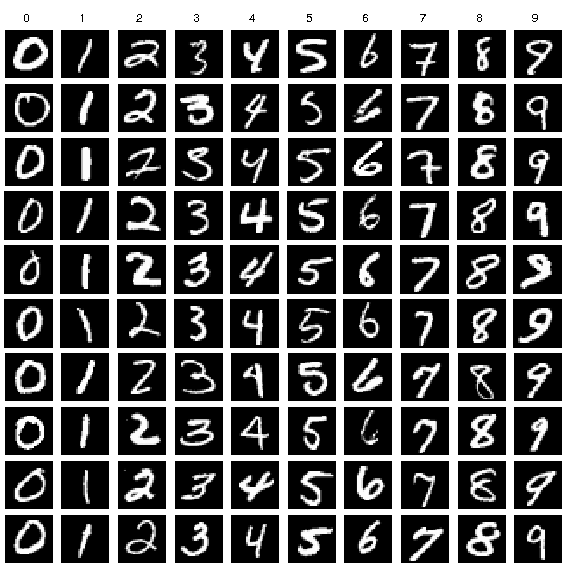

## Preparing Task: Download training and testing sets of MNIST using Pytorch framework

In [2]:
import torchvision

batch_size = 128

# implementation here
# Remember of transforming the images to tensors

# Libraries and packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
'''MNIST'''
training_data = MNIST( #60.000 samples for training and 10.000 for testing.
    root="data",       #root: caminho onde os dados serão armazenados localmente
    train=True,        #train: variável binária dados de treinamento (True) e teste (False)
    download=True,     #download: se True faz download da Internet caso os dados não estejam disponíveis localmente
    transform=ToTensor() #transform e target_transform especifica transformações para as features e labels.
)

testing_data = MNIST(
    root="data",
    train=False,        #train: treinamento (True) e teste (False)
    download=True,
    transform=ToTensor()
)
print("MNIST format:", training_data[0][0].shape, "Class of the first example:", training_data[0][1])

# Define dataloader
batch_size = 128
'''MNIST'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=batch_size)

MNIST format: torch.Size([1, 28, 28]) Class of the first example: 5


# 2. Denoising Convolutional Autoencoder

The concept of an Autoencoder is illustrated in the image above, comprising two fundamental components: the encoder and the decoder. The encoder takes the input, which in our case is a noisy image, and transforms it into a latent space representation. Subsequently, the decoder receives this encoded image and endeavors to reconstruct the original image, this time removing the noise from it.


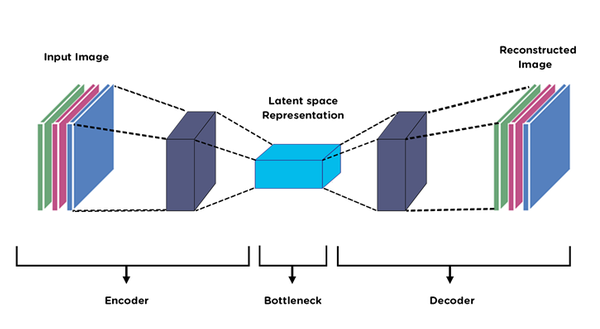

#### Adding noise to the images - Gaussian Noise

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torch

def add_noise(x, stddev=0.2):
    noise = torch.randn(x.size()) * stddev
    if x.is_cuda:
        noise = noise.to(device)
    noisy_x = x + noise
    return torch.clamp(noisy_x, 0, 1)

Visualizing original samples and samples with Gaussian noise

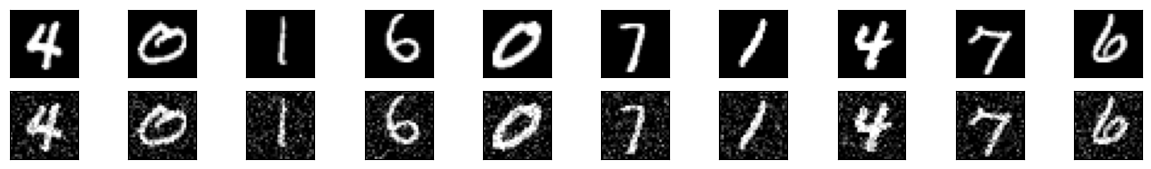

In [4]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
imgs, _ = next(dataiter)
noisy_imgs = add_noise(imgs)

n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## **Task 1:** (3 pts) Can you build a denoising Autoencoder?

#### Build a Denoising Autoencoder, following the configuration and parameters described in the instructions and image below

1. Implement a method for encoding, that takes an input image and generates a Vector of 128 dimensions,
2. Implement a method for decoding, that takes a vector of 128 dimensions and outputs an image,
3. The method `forward` will call the encoding and decoding methods.


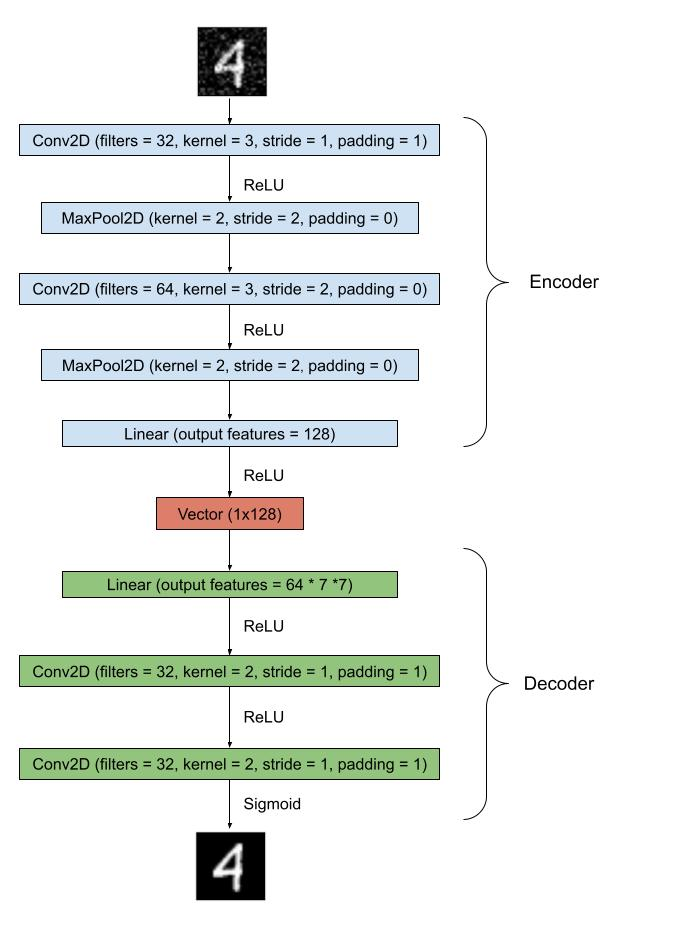


**Autoencoder: CORRECT architecture**

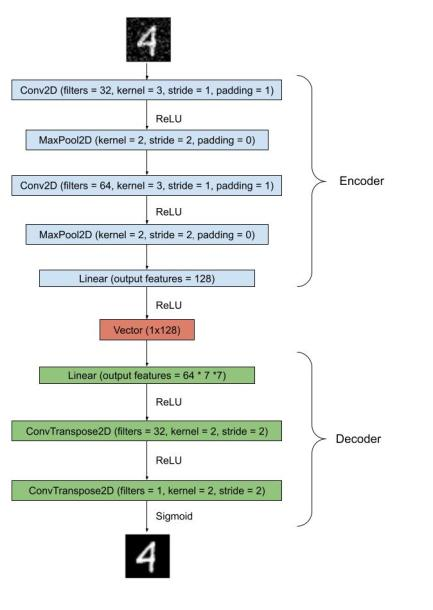

**Tip:** Be careful with dimensionality

When transitioning between convolutional and linear operations, it's essential to adapt the input of each layer accordingly.

Below, you can see an example on how to make this adjustment.

In [ ]:
# Changing the organization of an tensor

dataiter = iter(test_loader)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

# for flattening (to allow use linear layers) we need to change the dimension to a vector
vector = img.view(img.size(0), -1)
print("Vector shape:", vector.shape)
print("We can observe that the image 28x28 was transformed to a vector of 28*28 = 784", '\n')

# for the inverse
img = vector.view(vector.size(0), 28, 28)
print("Image shape:", img.shape, '\n')

Image shape: torch.Size([1, 28, 28]) 

Vector shape: torch.Size([1, 784])
We can observe that the image 28x28 was transformed to a vector of 28*28 = 784 

Image shape: torch.Size([1, 28, 28]) 



In [3]:
# Autoencoder architecture T2
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), #in_channels, out_channels= #filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )

    # flatten: tensor to vector (conv to linear)
    self.linear_encoder = nn.Sequential(
        nn.Linear(64*7*7, 128),
        nn.ReLU()
    )

    self.linear_decoder = nn.Sequential(
        nn.Linear(128, 64*7*7),
        nn.ReLU()
    )

    # (non)flatten: vector to tensor (linear to conv)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32,
                               kernel_size=2,
                               stride=2),
                               #padding=1,
                               #output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1,
                            kernel_size=2,
                            stride=2),
                            #padding=1,
                            #output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = x.view(x.size(0), -1) # for flattening (to allow use linear layers) we need to change the dimension to a vector
    x = self.linear_encoder(x)
    x = self.linear_decoder(x)
    x = x.view(x.size(0), 64, 7, 7) #64*7*7 # for the inverse (linear to conv; vector to tensor)
    x = self.decoder(x)
    return x

In [8]:
autoencoder = Autoencoder().to(device)
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_encoder): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear_decoder): Sequential(
    (0): Linear(in_features=128, out_features=3136, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


# 3. Training

## **Task 2:** (3 pts) Training the Autoencoder

Use the BCE Loss and the Adam optimizer with an initial learning rate of 0.0005

MNIST
Epoch [1/40], Loss: 0.1177
Epoch [6/40], Loss: 0.0799
Epoch [11/40], Loss: 0.0728
Epoch [16/40], Loss: 0.0684
Epoch [21/40], Loss: 0.0662
Epoch [26/40], Loss: 0.0701
Epoch [31/40], Loss: 0.0674
Epoch [36/40], Loss: 0.0683


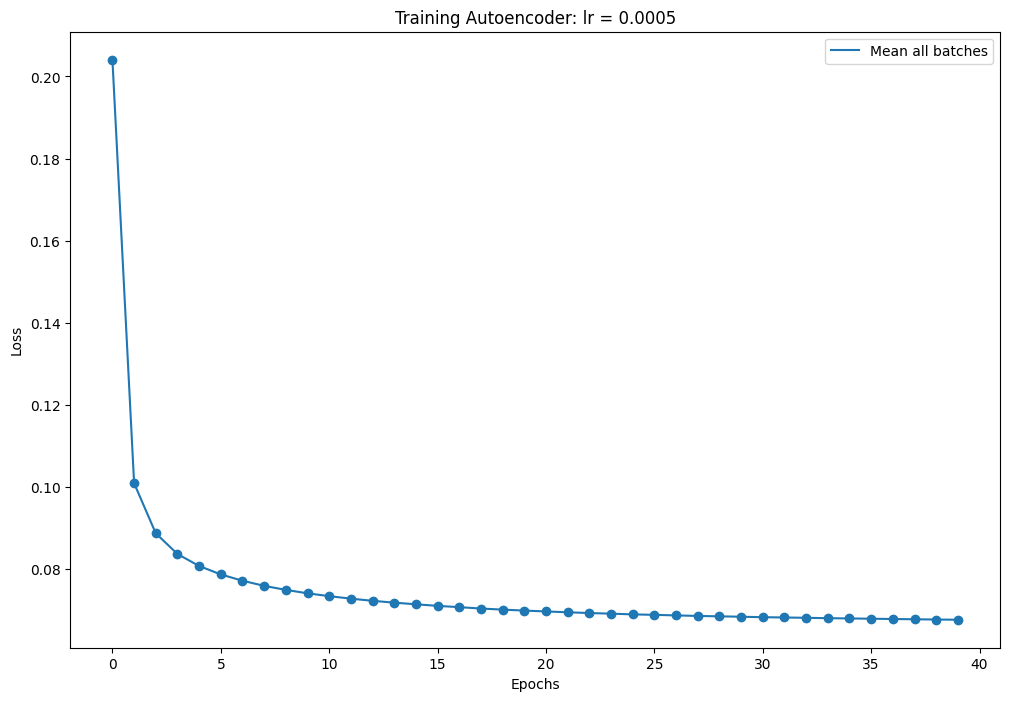

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)

num_epochs = 40

# Complete with the training algorithm
# Remember to change the device of the images
# Remember that we can see how the loss are changing along the epochs
EP = []
L = []

'''MNIST: 6m6s (gpu)'''
print("MNIST")
for epoch in range(num_epochs):
    ep = []
    l = []
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = autoencoder(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        # save data
        ep.append(epoch+1)
        l.append(loss.item())
    # save mean loss over all batches
    L.append(sum(l)/len(l))
    EP.append(epoch)
    if epoch % 5== 0: # print loss of the last batch of the epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Plot
plt.figure(figsize=(12, 8))
plt.plot(EP, L)               # mean over all batches
plt.scatter(EP, L)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Autoencoder: lr = 0.0005')
plt.legend(['Mean all batches'])
plt.show()

## **Task 2.1**: (0.5 pt) Name another loss function that could be used for training. Which images do we use for calculating the loss?

Answer: Outra função de perda que poderia ser utilizada para etapa de treinamento é o erro quadrático médio (MSELoss). Para o cálculo da perda (na Task 2), são empregadas as imagens de saída e de entrada do modelo, ou seja, a imagem original e sua reconstrução após passar pelas etapas de *encoder* e *decoder*.

No código temos a função de perda (*loss*) calculada como a comparação entre o *output* do modelo e *img*:
> `loss = criterion(output, img)` ,

sendo que o *output* é a saída do autoenconder e as imagens *img* vem do conjunto *train_loader* de imagens originais do dataset MNIST:
> ```
output = autoencoder(img)
```
> ```
for data in train_loader:
    img, _ = data
```

O interessante para um autoencoder é quando temos um caso como o da Task 3, no qual o objetivo é obter uma rede capaz de reduzir o ruído da imagem de entrada (denoising autoencoder). Nesse caso, a perda (loss) é calculada entre a imagem de saída do modelo (reconstrução da imagem de *input* ruidosa) e *o que se desejava obter*, no caso, a imagem original do conjunto MNIST sem ruído:
> ```
output = model(noise_img)
loss = criterion(output, img)
```

# 4. Visualizing the results

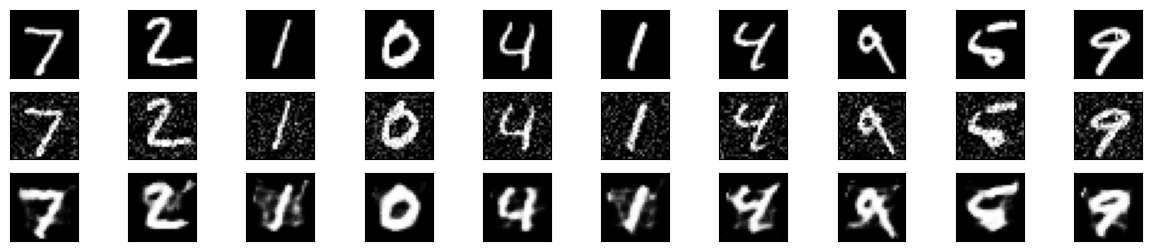

In [10]:
dataiter = iter(test_loader)
imgs, _ = next(dataiter)
imgs = imgs.cuda()
noisy_imgs = add_noise(imgs)



# Denoise the noisy images
denoised_imgs = autoencoder(noisy_imgs)

imgs = imgs.to(torch.device('cpu'))
noisy_imgs = noisy_imgs.to(torch.device('cpu'))
denoised_imgs = denoised_imgs.to(torch.device('cpu'))

# Visualize original, noisy, and denoised images
n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 5. Experimenting with different noise levels.

## **Task 3:** (3 pts): run an experiment, training 5 denoising autoencoders

Each model will be trained with images using different noise levels, parametrized by the following standard deviation values: 0.1, 0.2, 0.3, 0.4 and 0.5. Use 25 epochs for training.

After training:
1. On a single plot, show the curves of the loss functions evaluated on the training set for the 5 models.
2. Compare the 5 models, by:
  1. evaluating the average loss function value on the test set,
  2. showing images reconstructed by the 5 models

> Now the training_data has noise (no more the original images: MNIST + gaussian noise).

> The architecture of the autoencoder remains the same. The difference is the data it is going to receive in order to train (and therefore, learning).

> Save the 5 autocoders after the training in order to plot the reconstructed images (2).

MNIST: stddev =  0.1
Epoch [1/25], Loss: 0.1131
Epoch [6/25], Loss: 0.0774
Epoch [11/25], Loss: 0.0731
Epoch [16/25], Loss: 0.0716
Epoch [21/25], Loss: 0.0694
MNIST: stddev =  0.2
Epoch [1/25], Loss: 0.1233
Epoch [6/25], Loss: 0.0824
Epoch [11/25], Loss: 0.0789
Epoch [16/25], Loss: 0.0732
Epoch [21/25], Loss: 0.0736
MNIST: stddev =  0.3
Epoch [1/25], Loss: 0.1301
Epoch [6/25], Loss: 0.0893
Epoch [11/25], Loss: 0.0828
Epoch [16/25], Loss: 0.0842
Epoch [21/25], Loss: 0.0798
MNIST: stddev =  0.4
Epoch [1/25], Loss: 0.1286
Epoch [6/25], Loss: 0.0963
Epoch [11/25], Loss: 0.0962
Epoch [16/25], Loss: 0.0945
Epoch [21/25], Loss: 0.0919
MNIST: stddev =  0.5
Epoch [1/25], Loss: 0.1452
Epoch [6/25], Loss: 0.1028
Epoch [11/25], Loss: 0.1005
Epoch [16/25], Loss: 0.0987
Epoch [21/25], Loss: 0.1006


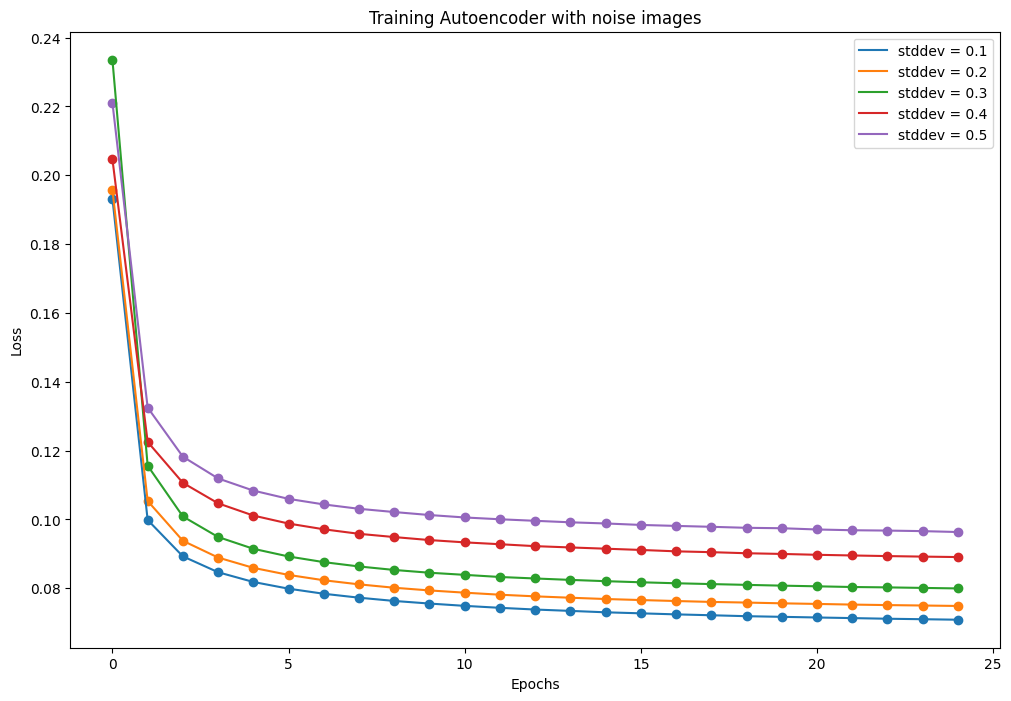

In [11]:
stddev = [0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(12,8))

LOSS = []
data_sim = {} # save data


for stdd in stddev:
  # Training dataset: adding noise
  dataiter = iter(train_loader)
  imgs, _ = next(dataiter)
  #noisy_imgs = add_noise(imgs, stdd)

  # Initialize the autoencoder
  model = Autoencoder()

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #print(device)
  model.to(device)

  # Define the loss function and optimizer
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0005)

  # Train the autoencoder
  num_epochs = 25

  # Loss(epoch): mean over all batches
  EP = []
  L = []

  '''MNIST'''
  print("MNIST: stddev = ", stdd)
  for epoch in range(num_epochs):
      ep = []
      l = []
      for data in train_loader:
          img, _ = data
          img = img.to(device)
          noise_img = add_noise(img, stdd) # adding noise
          optimizer.zero_grad()
          output = model(noise_img)
          loss = criterion(output, img)
          loss.backward()
          optimizer.step()
          # save data
          ep.append(epoch+1)
          l.append(loss.item())
      # save mean loss over all batches
      L.append(sum(l)/len(l))
      EP.append(epoch)
      if epoch % 5== 0: # print loss of the last batch of the epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

  # plot loss for the model given an stddev
  plt.plot(EP, L, label=f'stddev = {stdd}')
  plt.scatter(EP, L)

  # save losses for the model given an stddev
  LOSS.append(L)
  data_sim[f'{stdd}'] = L

  # save the autoencoder (parameters)
  torch.save(model, f'model_noise_{stdd}.pth')

# export data
data_sim['Epochs'] = EP
df = pd.DataFrame(data_sim)
df.to_csv('denoising_autoencoders_2.csv')

plt.title('Training Autoencoder with noise images')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

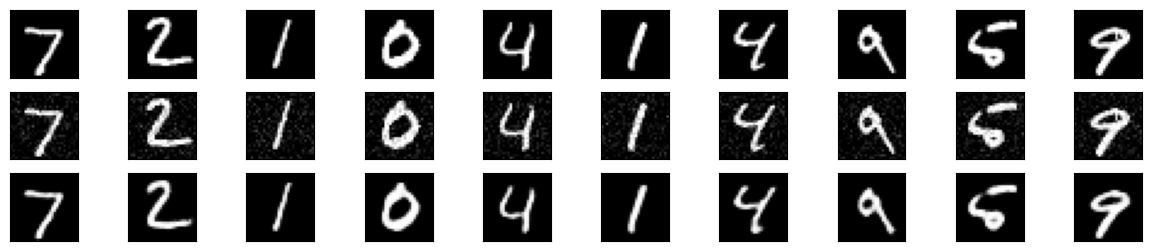

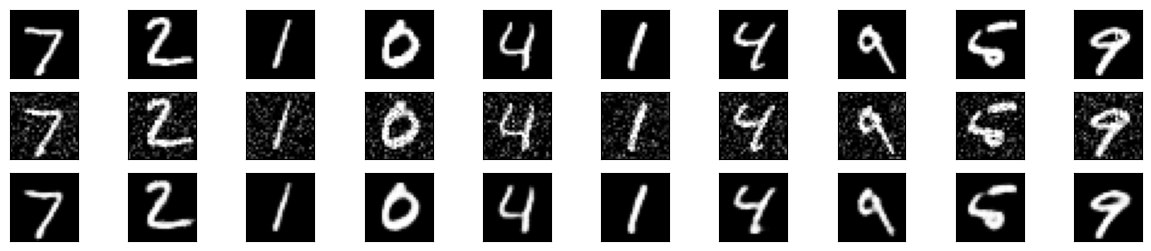

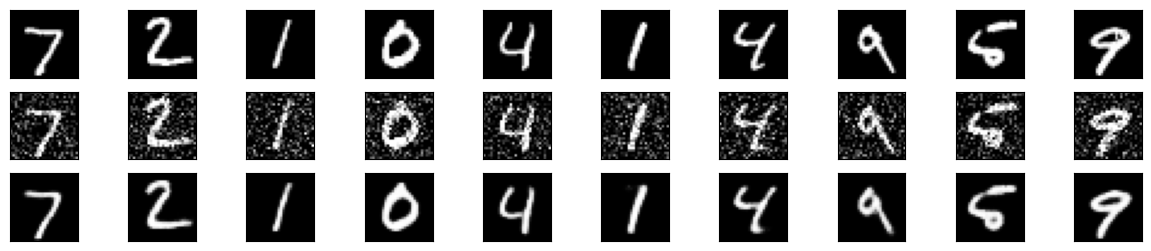

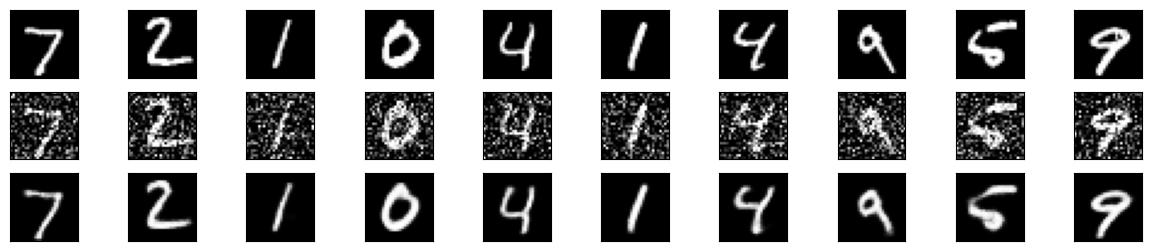

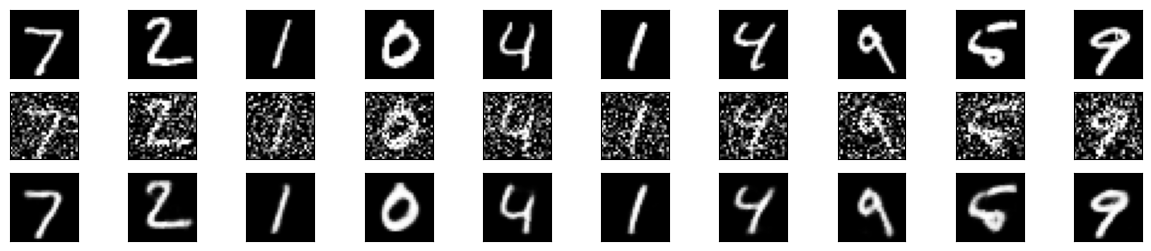

In [13]:
# showing images reconstructed by the 5 models
dataiter = iter(test_loader)
imgs, _ = next(dataiter)
imgs = imgs.cuda()
#noisy_imgs = add_noise(imgs)

# Loading trained models for each stddev
models = []
noisy_imgs_list = []
for stdd in stddev:
  models.append(torch.load(f'/content/model_noise_{stdd}.pth'))
  noisy_imgs_list.append(add_noise(imgs, stdd))

# Showing reconstructed images for each model
for model, noisy_imgs in zip(models, noisy_imgs_list):
  denoised_imgs = model(noisy_imgs)

  imgs = imgs.to(torch.device('cpu'))
  noisy_imgs = noisy_imgs.to(torch.device('cpu'))
  denoised_imgs = denoised_imgs.to(torch.device('cpu'))

  # Visualize original, noisy, and denoised images
  n = 10
  plt.figure(figsize=(15, 3))
  for i in range(n):

      # Original images
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Denoised images
      ax = plt.subplot(3, n, i + 1 + 2 * n)
      plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

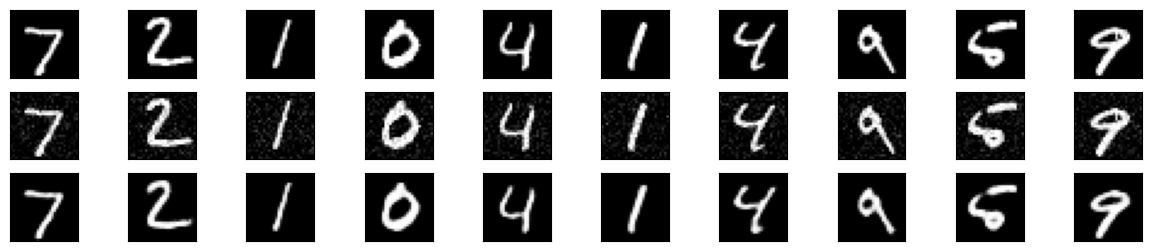

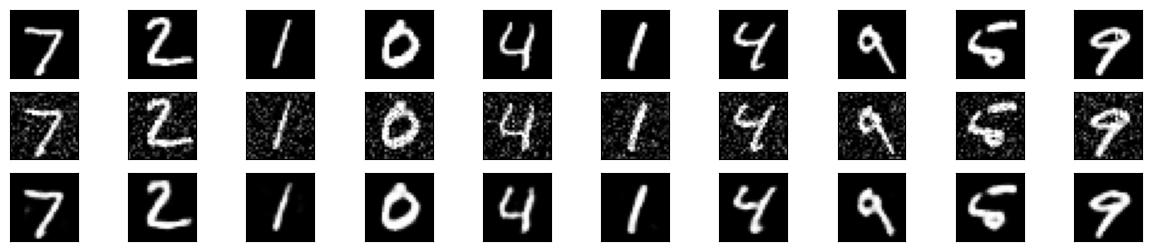

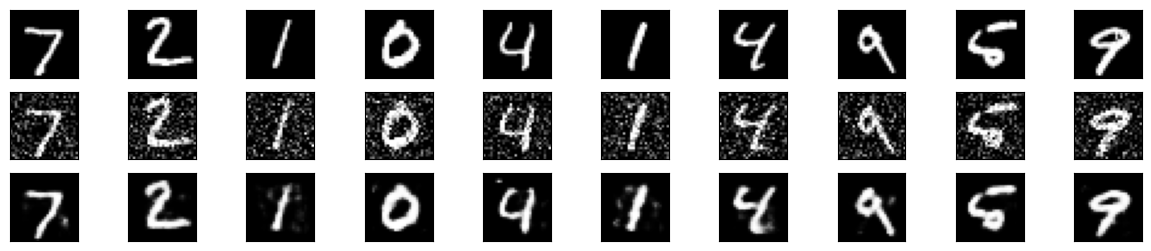

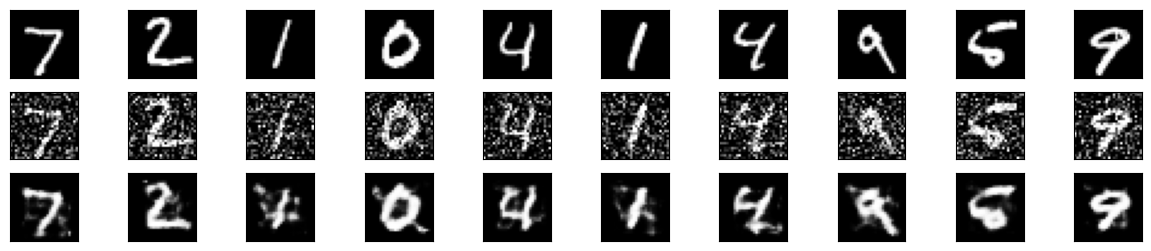

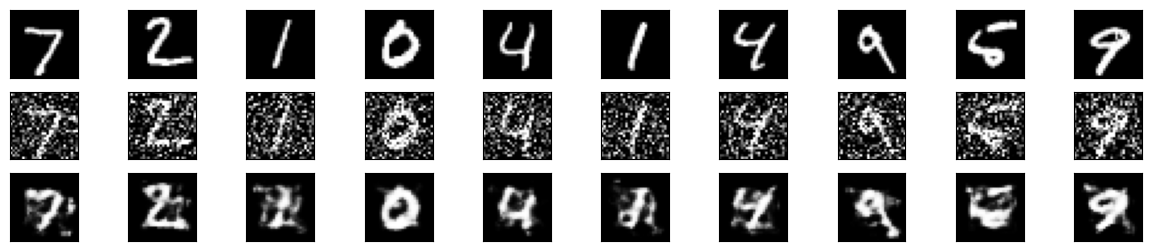

In [15]:
''' Showing images reconstructed by the autoencoder model trained with
 stddev = 0.1 with test_loaders with different noise levels'''

# Showing reconstructed images autoencoder stddev = 0.1
for noisy_imgs in noisy_imgs_list:
  denoised_imgs = models[0](noisy_imgs) #model stddev = 0.1

  imgs = imgs.to(torch.device('cpu'))
  noisy_imgs = noisy_imgs.to(torch.device('cpu'))
  denoised_imgs = denoised_imgs.to(torch.device('cpu'))

  # Visualize original, noisy, and denoised images
  n = 10
  plt.figure(figsize=(15, 3))
  for i in range(n):

      # Original images
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Denoised images
      ax = plt.subplot(3, n, i + 1 + 2 * n)
      plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

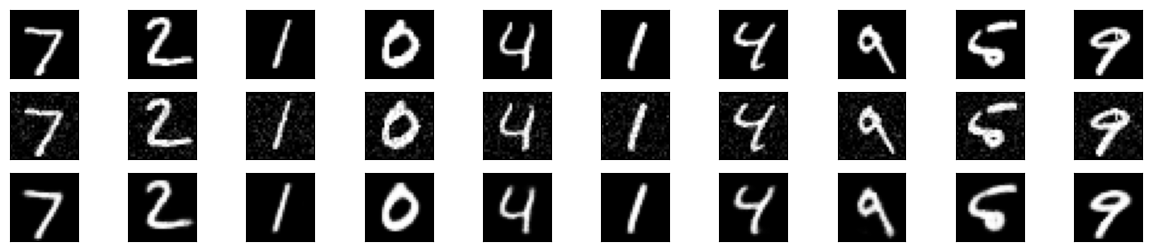

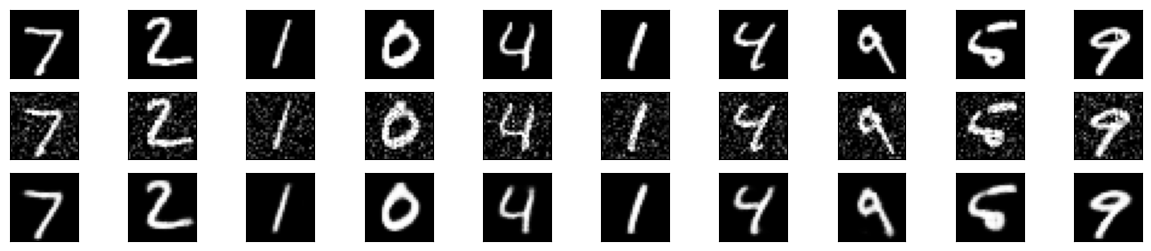

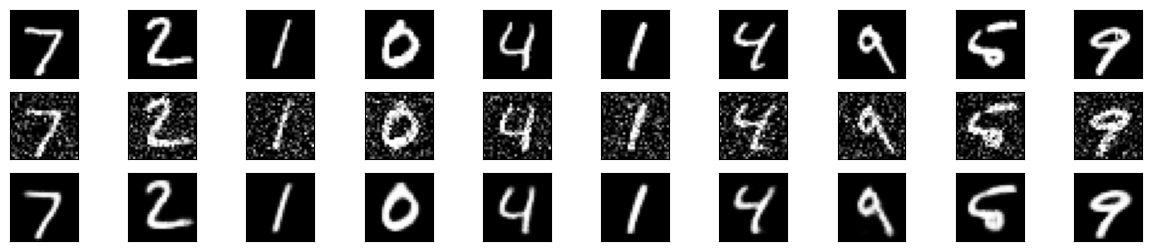

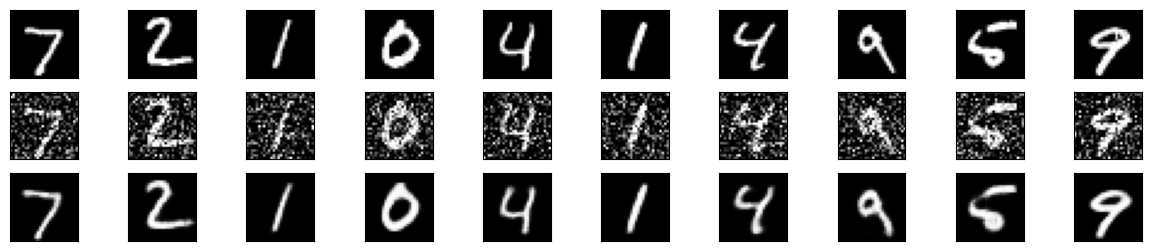

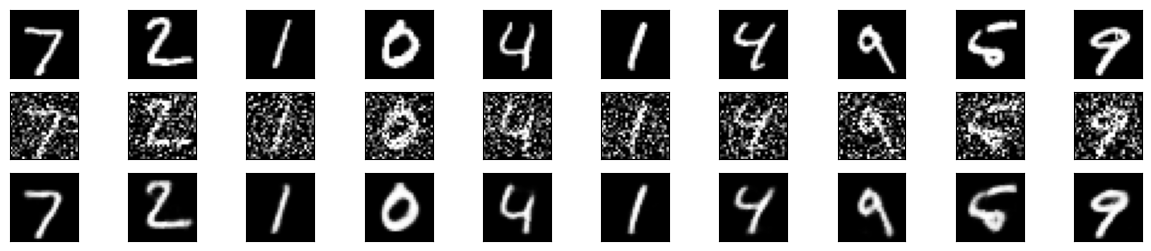

In [16]:
''' Showing images reconstructed by the autoencoder model trained with
 stddev = 0.5 with test_loaders with different noise levels'''

# Showing reconstructed images autoencoder stddev = 0.5
for noisy_imgs in noisy_imgs_list:
  denoised_imgs = models[4](noisy_imgs) #model stddev = 0.5

  imgs = imgs.to(torch.device('cpu'))
  noisy_imgs = noisy_imgs.to(torch.device('cpu'))
  denoised_imgs = denoised_imgs.to(torch.device('cpu'))

  # Visualize original, noisy, and denoised images
  n = 10
  plt.figure(figsize=(15, 3))
  for i in range(n):

      # Original images
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Denoised images
      ax = plt.subplot(3, n, i + 1 + 2 * n)
      plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

## **Task 3.1**: (0.5 pt) Write your observations about the experiments

Answer: No experimento envolvendo o treinamento de 5 decoders para diferentes níveis de ruído gaussiano, observou-se que a função de perda (loss) de cada um dos modelos diminui com o aumento das epochs, com o modelo para um desvio padrão de 0.1 apresentando menor perda, seguido por 0.2, 0.3, 0.4 e, por fim, o autoencoder treinado para ruído de 0.5 apresentando a maior perda ao final da etapa de treino. Para todos os modelos, a média da loss considerando todos os batches cai rapidamente nas primeiras epochs,  apresentando comportamento monotônico decrescente durante todo o processo.

A visualização das imagens reconstruídas pelos 5 modelos mostra que para um input de teste composto de imagens sujeitas ao mesmo nível de ruído do conjunto de treinamento do decoder, a reconstrução é praticamente perfeita. O output da rede é muito similar a imagem original, ou seja, os modelos foram capazes de aprender a codificar e decoficar imagens, sendo capazes de receber uma imagem ruidosa e reconstruí-la sem (ou com bem menos) ruído. Explorando a capacidade de reconstrução dos modelos quando sujeitos a conjuntos de teste com níveis de ruído diferentes do que foram originalmente treinados, observa-se que o modelo ainda é capaz de obter uma reconstrução com menos ruído gaussiano, no entanto a qualidade da imagem reconstruída é visualmente menor.
- Modelo treinado com stddev = 0.1: reconstrói muito próximo a perfeição as imagens teste de ruído gaussiano stddev = 0.1, no entanto, para os conjuntos de teste com maior nível de ruído a reconstrução piora conforme stddev aumenta. Para o maior nível de ruído, poderia-se dizer que algumas das imagens reconstruídas são até mesmo irreconhecíveis enquanto dígitos. Esse autoenconder não foi treinado para lidar com um nível tão alto de ruído.
- Modelo treinado com stddev = 0.5: por outro lado, ao submeter o modelo treinado com imagens de maior nível de ruído a conjuntos de imagens menos ruidosas, observa-se que este é capaz de reconstruir quase ao nível de perfeição todas as imagens de nível de ruído menor/igual ao seu.

Outro ponto que foi observado de modo geral é quanto a importância das GPUs ao se lidar com o treinamento de redes neurais com o uso de um grande conjunto de imagens de input por muitas epochs. O uso de GPU para rodar o modelo reduz drasticamente o tempo necessário para a etapa de treinamento, e torna viável a obtenção de resultados em tempo hábil. Para se ter noção da ordem de grandeza, a execução do treinamento dos 5 decoders da Tarefa 3, por exemplo, com o uso de GPU levou em torno de 20 minutos, enquanto sem, empregando somente CPU beirava os 250 minutos (!).

De modo geral, o trabalho mostrou de modo prático como uma rede autoencoder é capaz de aprender padrões de imagens e reconstruí-las com boa similaridade entre o output e a imagem original, a ponto ser capaz de reconstruir imagens ruidosas reduzindo seu nível de ruído.   

> Dados dos modelos treinados para os 5 decoders:
https://github.com/amanda-araujo/redes-neurais-aprendizado-profundo

# 6. Encoder as a feature extractor

## **Task 4:** optional/extra (1 pt) Training an external classifier

Use one of the trained models of your choice trained in task 3.

1. Use the `encoding` function to obtain a dataset of 128-dimensional features for all images of the training and testing sets. Convert those into numpy arrays.
2. Train a `LogisticRegression` classifier using the `sklearn` library using the training dataset (with 128 features obtained in step 1), see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for more information about this method.
3. Compute and print the accuracy score of the model for the training and testing sets.

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
model = torch.load(f'/content/model_noise_0.3.pth').to('cpu')

In [74]:
# Obtanting data
'''
To large set including all MNIST (60.000 images)!
Due to memory limitations, it was computed for the test_loader
(10.000 images of the MNIST dataset)
'''
features = []
targets = []

for data in test_loader:
  img, target = data

  # Encoder
  x = model.encoder(img)
  x = x.view(x.size(0), -1)
  x = model.linear_encoder(x)

  features.append(x.detach().numpy())
  targets.append(target.detach().numpy())

In [76]:
# Conversion to Numpy array
import numpy as np
features = np.asarray(features)[:-1]  #(16, 128) last
targets = np.asarray(targets)[:-1]

<ipython-input-76-f6cbb0c582b9>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.asarray(features)[:-1]  #(16, 128) last
<ipython-input-76-f6cbb0c582b9>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targets = np.asarray(targets)[:-1]


In [78]:
features = np.stack(features, axis=0)
targets = np.stack(targets, axis=0)

In [80]:
X = features.reshape(78*128, 128)
y = targets.reshape(78*128)

In [83]:
# Train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:
# Logistic Regression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('Acuracy: ', clf.score(X_test, y_test))

Acuracy:  0.9295902883156297


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> From an image of size 28*28, the encoder was able to represented it in a 128-dimensional vector, and to classify the digit with an acuracy of 92,959% (astonishing!).   